#*Support-vector Machine* (SVM) -- Parte I

Fontes da aula de hoje:
1. Capítulos 21 do *Livro Data Mining and Machine Learning: Fundamental Concepts and Algorithms* (https://dataminingbook.info/book_html/)

2. Várias páginas da documentação da ``scikit-learn``

# Introdução

## Nosso problema de interesse

Dados $D = \{(\mathbf{x}_i, y_i)\}_{i=1}^n$, a tarefa de classificação consiste em encontrar um modelo $f$ que aprenda dos vetores de características os rótulos.

Há dois requisitos principais:

1. Se $(\mathbf{x}, y) \in D$, então $f(\mathbf{x}) = y$ com alta probabilidade.

2. A função aprendida deve ser **generalizável**. Se um novo $\mathbf{x}$ não pertencente ao conjunto $D$ for observado, deseja-se também que $f(\mathbf{x})$ seja o rótulo correto de $\mathbf{x}$ com alta probabilidade.

**IMPORTANTE:** No contexto de SVM, vamos assumir que $y_i \in \{-1, 1\}$.

# Motivação e tarefa de hoje

Considere o conjunto de dados abaixo. Cada instância possui duas características, $u_1$ e $u_2$, e um rótulo, $y$.

O conjunto de dados é também apresentado pela figura seguinta.

In [ ]:
# Exemplo do livro texto

import numpy as np
import pandas as pd

df = pd.DataFrame([[3.5, 4.25, 1],
     [4, 3, 1],
     [4, 4, 1],
     [4.5, 1.75, 1],
     [4.9, 4.5, 1],
     [5, 4, 1],
     [5.5, 2.5, 1],
     [5.5, 3.5, 1],
     [0.5, 1.5, -1],
     [1, 2.5, -1],
     [1.25, 0.5, -1],
     [1.5, 1.5, -1],
     [2, 2, -1],
     [2.5, 0.75, -1]], columns = 'u1 u2 y'.split())

df

,u1,u2,y
0,3.50,4.25,1
1,4.00,3.00,1
2,4.00,4.00,1
3,4.50,1.75,1
4,4.90,4.50,1
5,5.00,4.00,1
6,5.50,2.50,1
7,5.50,3.50,1
8,0.50,1.50,-1
9,1.00,2.50,-1


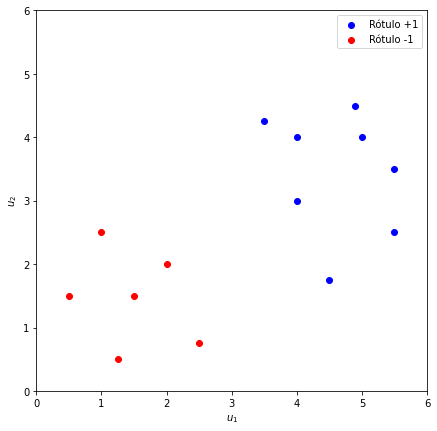

In [ ]:
import matplotlib.pyplot as plt

fig = plt.figure(figsize = (7, 7))
df1 = df[df['y'] == 1]
plt.scatter(df1['u1'], df1['u2'], c = 'blue', label = 'Rótulo +1')
df2 = df[df['y'] == -1]
plt.scatter(df2['u1'], df2['u2'], c = 'red', label = 'Rótulo -1')
plt.xlabel(r'$u_1$')
plt.ylabel(r'$u_2$')
plt.legend(loc = 'best');

plt.xlim((0, 6))
plt.ylim((0, 6));

Perguntas:
1. É possível separar os pontos de classes distintas com uma reta (hiperplano)?
2. Se sim, qual a melhor reta (hiperplano)?

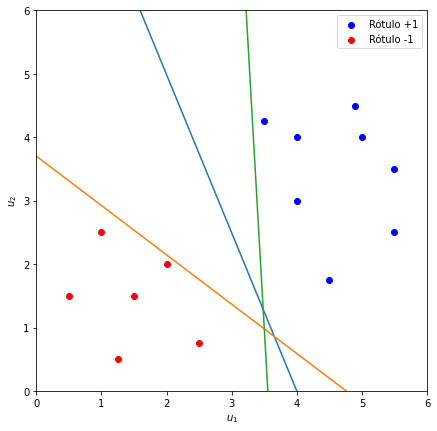

In [ ]:
import matplotlib.pyplot as plt

fig = plt.figure(figsize = (7, 7))
df1 = df[df['y'] == 1]
plt.scatter(df1['u1'], df1['u2'], c = 'blue', label = 'Rótulo +1')
df2 = df[df['y'] == -1]
plt.scatter(df2['u1'], df2['u2'], c = 'red', label = 'Rótulo -1')
plt.xlabel(r'$u_1$')
plt.ylabel(r'$u_2$')
plt.legend(loc = 'best');

x0 = np.array([0, 5])
y0 = -(1 / 0.334) * (0.833 * x0 - 3.332)
plt.plot(x0, y0)

y1 = -(1 / 0.9) * (0.7 * x0 - 3.332)
plt.plot(x0, y1)

y2 = -(1 / 0.05) * (0.9 * x0 - 3.2)
plt.plot(x0, y2)

plt.xlim((0, 6))
plt.ylim((0, 6));

Pode-se perceber que a linha de cor azul está equidistante das duas nuvens de pontos. Assim, parece mais adequada para realizar a separação.

Na aula de hoje, vamos construir um algoritmo que é capaz de encontrar essa linha no caso geral (qualquer dimensão).

# Problema de hoje

**Entrada:**
- um conjunto de pontos rotulados (problema de classificação binária) **que pode ser separado** por uma função linear (hiperplano)

**Objetivo:**
- Encontrar o "melhor" hiperplano de separação.

# Preliminares

Para resolver o problema proposto, precisamos relembrar vários conceitos relacionados à **geometria analítica**.

## Hiperplano

Um hiperplano no espaço $d$-dimensional é um conjunto de pontos $\mathbf{x} \in \mathbb{R}^d$ que satisfazem a equação $h(\mathbf{x}) = 0$, onde

$$h(\mathbf{x}) = \mathbf{w}^T\mathbf{x} + b = w_1x_1, + w_2x_2+\dots + w_dx_d + b.$$

Aqui, $\mathbf{w}$ é o vetor de pesos (ou coeficientes) e $b$ é um escalar (*bias*).

## Hiperplano de separação

- Um hiperplano separa o espaço $d$-dimensional em duas metades
- Um dataset é dito ser **linearmente separável** se há um hiperplano que separa os pontos das duas classes de forma pura.
>- Em outras palavras, para todos os pontos $\mathbf{x}$ com $h(\mathbf{x}) < 0$ tem-se rótulo -1; e para todos $\mathbf{x}$'s com $h(\mathbf{x}) > 0$ tem-se rótulo +1.
>- Nesse caso, o plano $h(\mathbf{x})$ pode ser visto como um classificador. Dado um elemento $\mathbf{z}$ a ser classificado, tem-se que o rótulo predito de $\mathbf{z}$ será +1 se $h(\mathbf{z}) > 0$ e -1, caso contrário.

## Distância Ponto-Hiperplano

Dados
- um hiperplano definido pelos pontos que satisfazem $h(\mathbf{x}) = 0$, com $h(\mathbf{x}) = \mathbf{w}^T\mathbf{x} + b$, e
- um ponto $\mathbf{z}$ que não está no hiperplano.
Qual a distância entre o hiperplano e o ponto?

A Figura abaixo (Fonte: livro texto) ilustra o problema.

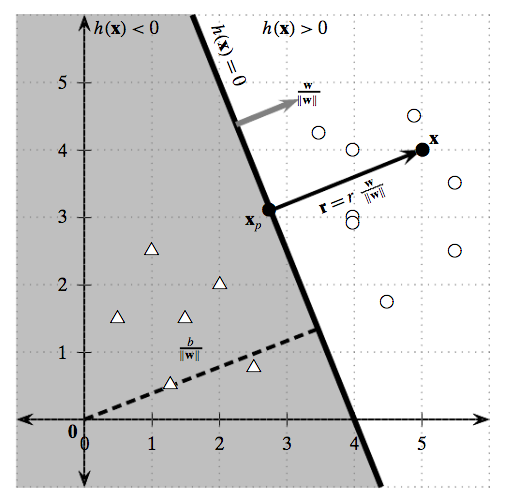

Pode-se mostrar que a distância entre o ponto e o hiperplano é dada por
$$\frac{|h(\mathbf{z})|}{\Vert\mathbf{w}\Vert}.$$

Especificamente no caso de um dataset rotulado e **linearmente separável** (situação de hoje), a distância acima pode ser reescrita como
$$\frac{yh(\mathbf{z})}{\Vert\mathbf{w}\Vert},$$
onde $y$ é o rótulo associado ao ponto $\mathbf{z}$.

Vejam que interessante... A distância depende do ponto, do hiperplano e do **rótulo** do ponto.

PS: essa derivação não é complicada e a leitura do livro texto é recomendada.

## Margem e vetores de suporte de um hiperplano

Dados
- um conjunto de treinamento $D = \{(\mathbf{x}_i, y_i)\}_{i = 1}^n$, com $y_i \in \{-1, 1\}$ que seja **linearmente separável**, e
- um hiperplano de separação $h(\mathbf{x}) = 0$ que separe $D$ em duas metades puras,

tem-se que a distância do hiperplano para cada ponto de $D$ é
$$\frac{y_ih(\mathbf{x}_i)}{\Vert\mathbf{w}\Vert} = \frac{y_i(\mathbf{w}^T\mathbf{x}_i+b)}{\Vert\mathbf{w}\Vert}.$$

A **margem** de $h$ com respeito a $D$ é definida por
$$\min_{i}\left\{\frac{y_i(\mathbf{w}^T\mathbf{x}_i+b)}{\Vert\mathbf{w}\Vert}\right\}.$$
Em outras palavras, a margem é a menor distância entre o hiperplano e qualquer ponto do conjunto de dados.

Todos os pontos (ou vetores) que estejam sobre a margem (i.e., tenham distância mínima para o hiperplano) são chamados de **vetores de suporte** do hiperplano.

PS: esses vetores são importantes para o classificador que estamos desenvolvendo. Daí o nome *Support-vector Machine*.

## Hiperplano Canônico

O mesmo hiperplano pode ser representado por uma infinidades de coeficientes $\mathbf{w}$ e $b$.

Por exemplo, as equações abaixo definem o mesmo conjunto de pontos (hiperplanos):
1. $2x_1 + 3x_2 + 1 = 0$
2. $4x_1 + 6x_2 + 2 = 0$
3. $2\alpha x_1 + 3\alpha x_2 + \alpha = 0$, para todo $\alpha \neq 0$.

Um truque na formulação do SVM é fixar $\mathbf{w}$ e $b$ de uma forma específica. Essa forma específica é denotada por **hiperplano canônico**.

A representação canônica de um hiperplano é tal que a **margem** do hiperplano tenha tamanho $\frac{1}{\Vert\mathbf{w}\Vert}$.

O conceito é representado na Figura abaixo (fonte: livro texto).

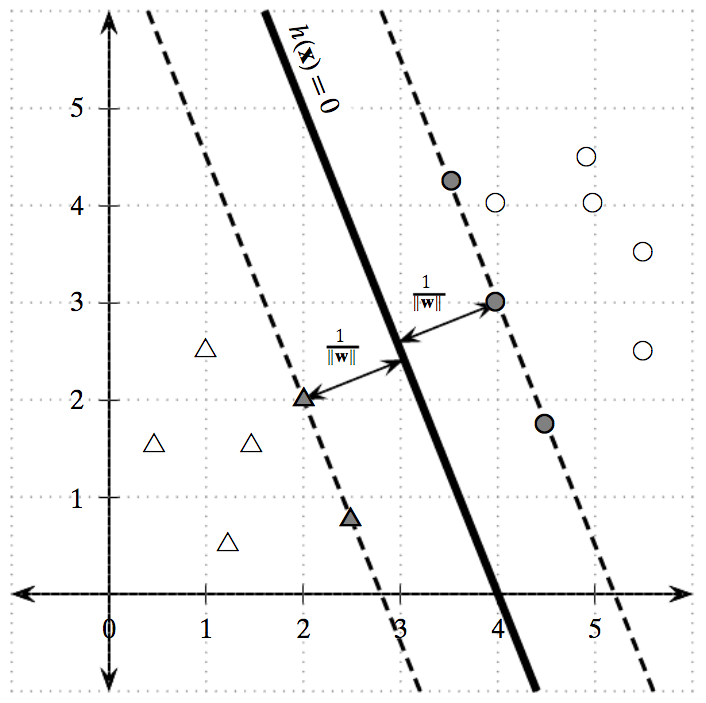

Ao utilizar a representação canônica, tem-se, para todo $(\mathbf{x}_i, y_i) \in D$ que:
$$
\frac{y_i(\mathbf{w}^T\mathbf{x}_i+b)}{\Vert\mathbf{w}\Vert} \ge \frac{1}{\Vert\mathbf{w}\Vert}.
$$

Na parte da esquerda temos a distância entre cada ponto e o hiperplano. Na parte da direita temos o tamanho da margem (que é o menor valor dessas distâncias).

Como consequência, tem-se, para todo $(\mathbf{x}_i, y_i) \in D$ que:
$$
y_i(\mathbf{w}^T\mathbf{x}_i+b) \ge 1.
$$

# SVM: Caso linearmente separável

### Formulação

Considere um conjunto de treinamento $D = \{(\mathbf{x}_i, y_i)\}_{i = 1}^n$, com $y_i \in \{-1, 1\}$ que seja **linearmente separável**.

A ideia fundamental do SVM é encontrar a representação canônica de um hiperplano de separação que tenha **margem máxima** entre todos os hiperplanos de separação (que separem $D$ de forma pura).

Assim, nosso problema é transformado no seguinte problema de otimização:

**Função objetivo:**
$$\max_{\mathbf{w}, b} \frac{1}{\Vert\mathbf{w}\Vert}$$

**Restrições:** $y_i(\mathbf{w}^T\mathbf{x}_i+b) \ge 1$, para $i = 1, \dots, n$.

O problema acima é equivalente ao seguinte problema.

**Função objetivo:**
$$\min_{\mathbf{w}, b} \frac{\Vert\mathbf{w}\Vert^2}{2}$$

**Restrições:** $y_i(\mathbf{w}^T\mathbf{x}_i+b) \ge 1$, para $i = 1, \dots, n$.

E é esse problema de otimização que, geralmente, é abordado!

### Solução

**checkpoint:** até aqui, como estamos? A matemática pode ser abstrata, mas como está a intuição?

O problema de otimização descrito acima pode ser resolvido diretamente. No entanto, "coisas" bem interessantes ocorrem quando nós abordamos o *dual* do problema.

Para isso, vamos recorrer aos **multiplicadores de Lagrange** e **condições KKT** (Referência [aqui](https://en.wikipedia.org/wiki/Karush%E2%80%93Kuhn%E2%80%93Tucker_conditions))

**WARNING:** A partir de agora, vamos recorrer a alguns conceitos mais avançados... *Some equations may cause mental distress*...

#### Passo 1 - A função Lagrangiana

Dado o problema de otimização formulado, podemos combinar a funcão objetivo e as restrições do problema para obter a função Lagrangiana.
$$
\mathcal{L}(\mathbf{w}, b, \mathbf{\alpha}) = \frac{1}{2}\Vert\mathbf{w}\Vert^2 - \sum_{i = 1}^n\alpha_i(y_i(\mathbf{w}^T\mathbf{x}_i+b) - 1),
$$
com $\alpha_i \ge 0$, $i = 1, \dots, n$.

A ideia aqui é que a solução do nosso problema de interesse está no **ponto de sela** de $\mathcal{L}$. Exemplo [aqui](https://en.wikipedia.org/wiki/Saddle_point).

Em outras palavras, temos que minimizar $\mathcal{L}$ com respeito a $\mathbf{w}$ e $b$, e maximizar com respeito a $\mathbf{\alpha}$.

#### Passo 2 - Minimizando $\mathcal{L}$ com respeito a $\mathbf{w}$ e $b$

Nesta etapa, vamos proceder como usual em cálculo de várias variáveis. Queremos:
1. $\frac{\partial \mathcal{L}(\mathbf{w}, b, \mathbf{\alpha})}{\partial \mathbf{w}} = \mathbf{0}$
2. $\frac{\partial \mathcal{L}(\mathbf{w}, b, \mathbf{\alpha})}{\partial b} = 0$

Com alguma ágebra depois... tem-se que:
$$\mathbf{w} = \sum_{i = 1}^n\alpha_iy_i\mathbf{x}_i \quad\text{  e  }\quad \sum_{i=1}\alpha_iy_i = 0.$$





#### Passo 3 - Maximizando $\mathcal{L}$ com respeito a $\mathbf{\alpha}$

Realimentando o resultado do Passo 2 em $\mathcal{L}$ e com algum algebrismo, obtemos o *dual* de nosso problema de otimização.

**Função objetivo:**

$$\max_{\mathbf{\alpha}} \sum_{i = 1}^n\alpha_i - \frac{1}{2}\sum_{i = 1}^n\sum_{j = 1}^n\alpha_i\alpha_jy_iy_j\mathbf{x}_i^T\mathbf{x}_j$$

**Restrições:**
1. $\alpha_i \ge 0$, $i = 1, \dots, n$.
2. $\sum_{i = 1}^n\alpha_iy_i = 0$

#### Passo 4 - Condições KKT

Da teoria de Otimização não linear e das KKT *conditions*, tem-se, no ponto de sela de $\mathcal{L}$, que:

$$\alpha_i(y_i(\mathbf{w}^T\mathbf{x}_i+b) - 1) = 0,$$
para $i = 1, \dots, n$.

Desse resultado, há apenas duas possibilidades:
1. $\alpha_i = 0$; ou
2. $y_i(\mathbf{w}^T\mathbf{x}_i+b) = 1$.

Repare que os pontos que satisfazem a segunda possibilidade estão sobre margem (i.e., **vetores de supporte**). Assim, como implicação das condições de KKT, temos que $\alpha_i \neq 0$ apenas para os vetores de suporte.

#### Passo 5 - Resolver o *dual*

Isso é mais um problema de computação numérica e está fora do escopo deste curso...

Vamos assumir de agora em diante, que os $\alpha_i$'s foram encontrados!

A solução ótima do problema dual será denotada por $\mathbf{\alpha}^*$.

#### Passo 6 - Obtendo $\mathbf{w}$ e $b$

Vamos denotar por $S$ o conjunto de índices dos vetores de suporte. Como $\alpha^* = 0$ para todo elemento cujo índice não estiver em $S$, temos que:

$$\mathbf{w} = \sum_{i = 1}^n\alpha_i^*y_i\mathbf{x}_i = \sum_{i \in S}^n\alpha_i^*y_i\mathbf{x}_i.$$

Com um pouco mais de algebrismo (omitido aqui), $b$ também pode ser computado em função dos vetores de suporte.

Em **resumo**, após a otimização do problema *dual*, $\mathbf{w}$ e $b$ podem ser obtidos apenas com os vetores de suporte!!!

E com isso, concluímos o desafio da aula de hoje!

# What is next?

O que fazer quando o problema não for linearmente separável?